In [1]:
import os
import sys
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)



from srcs.engdataset import ENGDataset, Nerve
import utils.preprocessing as pre
import utils.classify as classify
import utils.plot as uplot
from constants import *

from collections import Counter
import logging
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from typing import Dict, List
import seaborn as sns
import re

plt.rcParams.update({"figure.dpi": 150})
plt.rcParams['axes.axisbelow'] = True
logging.getLogger().setLevel(logging.INFO)
matplotlib.rcParams.update({'font.size': 6})

plt.rcParams.update({
            "figure.dpi": 150, 'font.size': 10,
            'figure.figsize': (5,3), 'axes.axisbelow': True,
            'axes.edgecolor': COLOR_DICT['clouds'], 'axes.linewidth': 0.4
        })

logging.getLogger().setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

# Load data

In [2]:
# load raw ENG for the following parameters
day = 16                   # day of recording
session = '01'             # session of recording

preproc_plots = False      # whether to plot figures during preprocessing
filter_signal = False      # whether to filter all channels if set to True or reload a saved file with filtered data if set to False
save_figs = True

Gest_namedtup = namedtuple('gesture', ['id', 'phase'])


In [3]:
# create directory for figures
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)
if not os.path.exists(CLF_FIG):
    os.makedirs(CLF_FIG)
if not os.path.exists(FILTERED_DIR):
    os.makedirs(FILTERED_DIR)

CLF_FIG = os.path.join(FIG_DIR, 'clf')
if not os.path.exists(CLF_FIG):
    os.makedirs(CLF_FIG)

In [4]:
eng_dataset = ENGDataset(day= day, session=session, load_raw_data = True, save_figs=save_figs)
pipeline = {'bp_order': 3, 'bp_cutoff_freq': np.array([300, 2000]), 'notch_bandwidth': 0.5, 'notch_reject': 50}
eng_dataset.filt_pipeline = pipeline

INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG.mat
INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG_ok.mat
INFO:root:Creating dictionary of reps count per task: {0: 10, 1: 10, 2: 10, 3: 7, 4: 10}
INFO:root:Time column of post_data(7157879,) 
Rec column of post_data(56, 7157879)


# Filter channels

In [5]:
if filter_signal: # filter all channels and plot the bandpassed version
    notch_filt_data, bp_filt_data = pre.apply_filter_pipeline(eng_dataset)

    if preproc_plots:
    # plot single ch fft after filtering
        fig = plt.figure(figsize=(8, 4))
        gs = gridspec.GridSpec(nrows=3, ncols=1)
        sel_ch = 0
        xlim = [0,  pipeline['bp_cutoff_freq'][-1]]  # in Hz

        xf_raw, yf_raw = pre.get_fft(np.array(eng_dataset.post_data_df[sel_ch]), ENG_FS)

        xf_bp, yf_bp = pre.get_fft(bp_filt_data[:, sel_ch], ENG_FS)
        xf_not, yf_not = pre.get_fft(notch_filt_data[:, sel_ch], ENG_FS)

        ax = fig.add_subplot(gs[0])
        ax.plot(xf_raw, np.sqrt(np.abs(yf_raw)), label='raw', color=COLOR_DICT['midnight_blue'])
        ax.set(frame_on=False)
        plt.xlim(xlim)
        plt.ylabel('amplitude [uV]')
        plt.title(f"Signal ch:{sel_ch} after Notch filters + BP: {pipeline['bp_cutoff_freq']}", fontsize=8)

        ax2 = fig.add_subplot(gs[1])
        ax2.plot(xf_not, np.sqrt(np.abs(yf_not)), label='Notch', color=COLOR_DICT['pumpkin'])
        ax2.set(frame_on=False)
        plt.legend()
        plt.xlim(xlim)

        # plt.xticks(ticks=np.arange(-0,1000,50))
        plt.ylabel('amplitude [uV]')

        ax1 = fig.add_subplot(gs[2])
        ax1.plot(xf_bp, np.sqrt(np.abs(yf_bp)), label='BPF', color=COLOR_DICT['midnight_blue'])
        ax1.set(frame_on=False)
        plt.legend()
        plt.xlim(xlim)
        plt.ylabel('amplitude [uV]')
        plt.xlabel('freq [Hz]')
        plt.show()

        fig.savefig(f"figures/fft_bp_{pipeline['bp_cutoff_freq'][0]}_"
                    f"{pipeline['bp_cutoff_freq'][1]}.png")

In [6]:
# save filtered data to pickle or load from pickle a presaved filtered data
filt_filename = f"day{eng_dataset.day}{eng_dataset.session}_eng_filt_{eng_dataset.filt_pipeline['bp_cutoff_freq'][0]}_{eng_dataset.filt_pipeline['bp_cutoff_freq'][1]}.pkl"
if filter_signal:
    # organize filtered data in dataframe
    filt_df = pd.DataFrame(bp_filt_data)
    filt_df[TIME_VAR] = eng_dataset.post_data_df[TIME_VAR]
    filt_df.to_pickle(os.path.join(FILTERED_DIR, filt_filename))
else:
    logging.info(f"Loading filtered data from {filt_filename}")
    filt_df = pd.read_pickle(os.path.join(FILTERED_DIR, filt_filename))
eng_dataset.filt_df = filt_df


INFO:root:Loading filtered data from day1601_eng_filt_300_2000.pkl


In [7]:
# get bad channels
bad_channels, bad_channels_std = pre.detect_bad_channels(eng_dataset, std_threshold=5)
print(f"Bad channels:{bad_channels}\nBad channels std:{np.round(bad_channels_std,3)}")

INFO:root:Nerve.MEDIAN_E1: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Channels median of stds: 0.9994738317477818

INFO:root:Nerve.MEDIAN_E2: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Channels median of stds: 1.5129269970719061

INFO:root:Nerve.ULNAR_E1: [28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Channels median of stds: 1.2218176684677338

INFO:root:Nerve.ULNAR_E2: [42 43 44 45 46 47 48 49 50 51 52 53 54 55]
Channels median of stds: 1.3015219241400366



Bad channels:[1, 2, 5, 7, 43]
Bad channels std:[8.39  6.585 6.036 6.101 7.675]


# Visualize
## Plot filtered signal

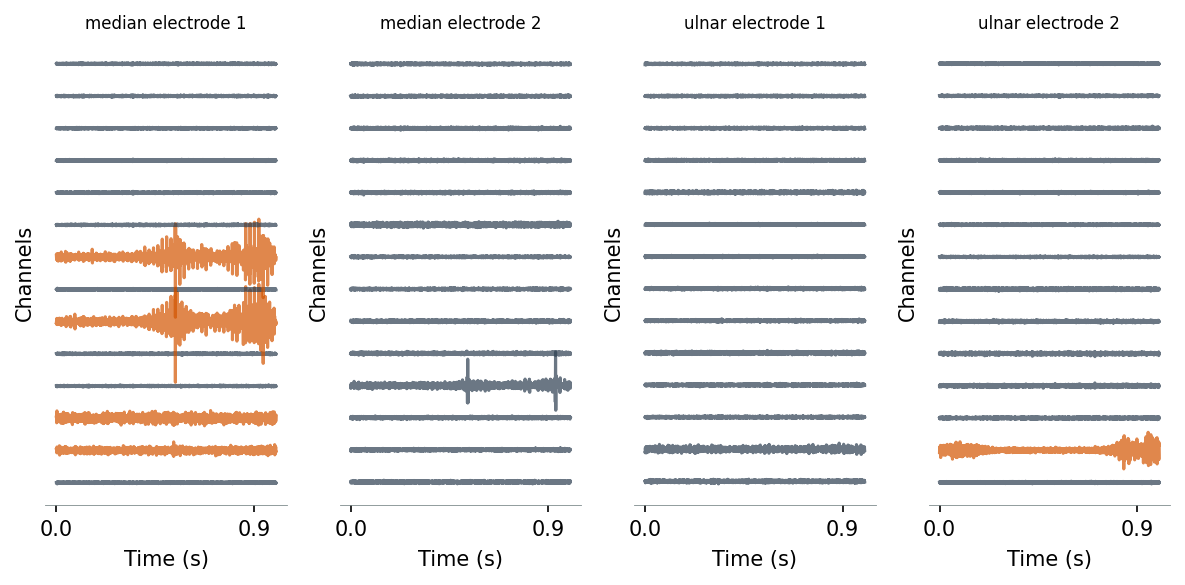

In [10]:
# 4 rows,  1 column 
task_id = 0


yshift = 100  # shift in y axis for each channel
time_dur = 1  # duration of the task in seconds
plot_phase= 'close'  # 'open' or 'close'

for rep_id in [4]:#range(eng_dataset.task_rep_count[task_id]):
    fig = plt.figure(figsize=(8, 4))
    gs = gridspec.GridSpec(nrows=1, ncols=4)
    task_rep_s, task_rep_e = pre.get_trig_start_end_for_task(eng_dataset.filt_df,
                                                                eng_dataset.trig_df,
                                                                rep_id=rep_id,
                                                                task_id=task_id,
                                                                n_reps_dict=eng_dataset.task_rep_count)
    task_mask = (eng_dataset.filt_df[TIME_VAR] >= task_rep_s) & (eng_dataset.filt_df[TIME_VAR] <= task_rep_e)

    if plot_phase == 'close':  # flexion/close phase
        time_start = task_rep_s   
        time_end = task_rep_s +  time_dur

    elif plot_phase == 'open':  # extension/ open phase
        time_start = task_rep_s + time_dur
        time_end = task_rep_s + 2*time_dur


    time_mask =   (eng_dataset.filt_df[TIME_VAR] >= time_start) & (eng_dataset.filt_df[TIME_VAR] <= time_end)

    for col, elec in enumerate(range(eng_dataset.n_electrodes)):
        nerve_elec = list(Nerve)[elec]
        ch_group = eng_dataset.nerves_ch_group[nerve_elec]

        ax = fig.add_subplot(gs[col])
        for i, plot_ch in enumerate(ch_group):
            if plot_ch in bad_channels:
                color = COLOR_DICT['pumpkin']
            else:
                color = COLOR_DICT['midnight_blue']
            ax.plot(eng_dataset.filt_df[TIME_VAR].to_numpy()[time_mask], 
                    eng_dataset.filt_df[plot_ch].to_numpy()[time_mask] + yshift*i,
                    color=color, alpha = 0.7)
        
        # ax.set_yticks(np.arange(0, yshift*len(ch_group), yshift),
        #             labels=ch_group)
        ax.set_yticks([])
        elec_nb = re.findall(r'\d+', nerve_elec.name)[0]
        ax.set_title(f"{nerve_elec.name.split('_')[0].lower()} electrode {elec_nb}", fontsize=8)
        # ax.set_ylabel(f"Channels {nerve_elec.name.split('_')[0].lower()} electrode {elec_nb}", labelpad=YLAB_PAD)
        ax.set_ylabel(f"Channels", labelpad=YLAB_PAD)

        ax.set_xlabel('Time (s)', labelpad=XLAB_PAD)
        ax.set_xticks(np.arange(time_start, time_end, 0.9), labels= np.arange(0, time_dur, 0.9))
        # sns.despine(ax=ax, top=True, right=True)
        sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)

        

    fig.tight_layout()

    # save figure
    fig.savefig(os.path.join(FIG_DIR, 
                f"day{eng_dataset.day}{eng_dataset.session}_task{task_id}_rep{rep_id}_channels_t{time_start:.2f}_{time_end:.2f}_{plot_phase}.png"),
                dpi=300, bbox_inches='tight')



## Plot feature

In [129]:
bad_channels

[1, 2, 5, 7, 43]

Bad channel 1
Bad channel 2
Bad channel 5
Bad channel 7
Bad channel 43


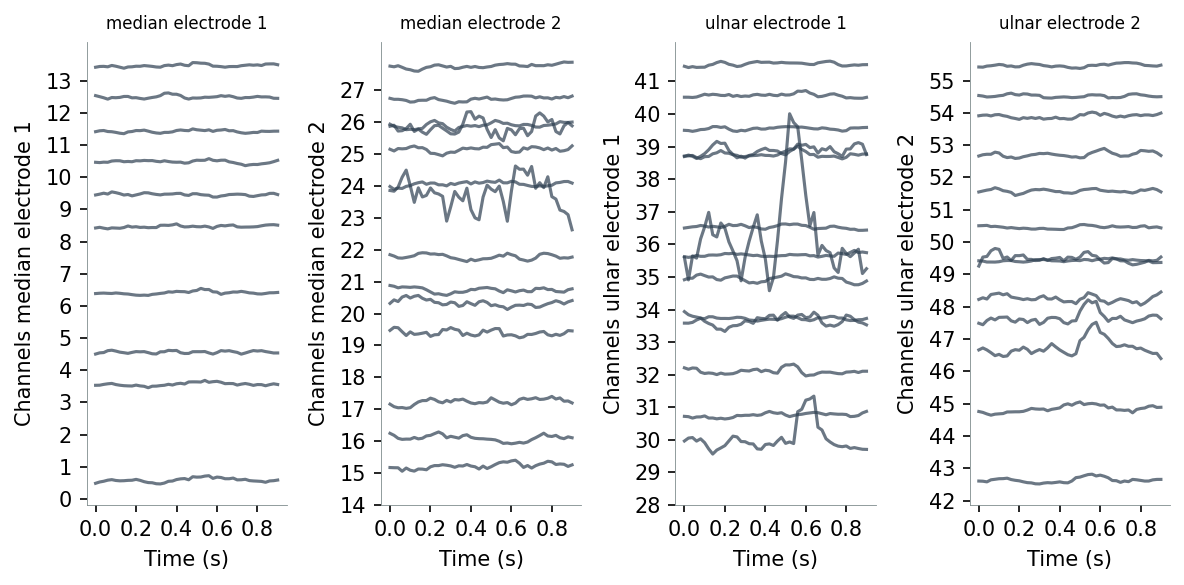

In [145]:
task_id = 1
feature = 'power'
wind_size = 0.1
ol = 0.8


plot_phase= 'close'  # 'open' or 'close'
yshift = 2 #35  # shift in y axis for each channel

for rep_id in range(1): #eng_dataset.task_rep_count[task_id]): 
    fig = plt.figure(figsize=(8, 4))
    gs = gridspec.GridSpec(nrows=1, ncols=4)
    flex_feat_df, ext_feat_df, rest_feat_df = pre.extract_feature_for_task_rep_per_phase(eng_dataset,
                                                                                   task_id,
                                                                                   rep_id,
                                                                                   feature,
                                                                                   wind_size,
                                                                                   overlap_perc=ol)
    
    if plot_phase == 'close':  # flexion/close phase
        plot_phase_df = flex_feat_df

    elif plot_phase == 'open':  # extension/ open phase
        plot_phase_df = ext_feat_df


    for col, elec in enumerate(range(eng_dataset.n_electrodes)):
        nerve_elec = list(Nerve)[elec]
        ch_group = eng_dataset.nerves_ch_group[nerve_elec]
        # yshift = 0 #35  # shift in y axis for each channel
        # list_yshift = []
        # list_good_ch = []
  
        ax = fig.add_subplot(gs[col])
        for i, plot_ch in enumerate(ch_group):
            if plot_ch in bad_channels:
                print(f"Bad channel {plot_ch}")
                continue
            else:
                color = COLOR_DICT['midnight_blue']

            # adjust the yshift
            
            ax.plot(plot_phase_df[TIME_VAR].to_numpy(), 
                    plot_phase_df[plot_ch].to_numpy() + yshift*i,
                    color=color, alpha = 0.7)
            # ch_range  = (plot_phase_df[plot_ch].to_numpy().max() - plot_phase_df[plot_ch].to_numpy().min())
            # ch_range = plot_phase_df[plot_ch].to_numpy().max()
            # min_ch = plot_phase_df[plot_ch].to_numpy().min()
            # if col==1:
            #     print(i, plot_ch, ch_range, yshift)

            # yshift += ch_range 
            # list_yshift.append(yshift)
            # list_good_ch.append(plot_ch)
            
        
        ax.set_yticks(np.arange(0, yshift*len(ch_group), yshift), labels=ch_group)
        # ax.set_ylim(-5, yshift*len(ch_group))
        # ax.set_yticks(list_yshift, labels=list_good_ch)
        elec_nb = re.findall(r'\d+', nerve_elec.name)[0]

        ax.set_title(f"{nerve_elec.name.split('_')[0].lower()} electrode {elec_nb}", fontsize=8)
        ax.set_ylabel(f"Channels {nerve_elec.name.split('_')[0].lower()} electrode {elec_nb}", 
                      labelpad=YLAB_PAD)
        ax.set_xlabel('Time (s)', labelpad=XLAB_PAD)
        ax.set_xticks(plot_phase_df[TIME_VAR].to_numpy()[::10])
        
        sns.despine(ax=ax, top=True, right=True)
    
    fig.tight_layout()
    # save figure
    # fig.savefig(os.path.join(FIG_DIR, 
    #             f"day{eng_dataset.day}{eng_dataset.session}_task{task_id}_rep{rep_id}_{feature}_t{time_start:.2f}_{time_end:.2f}_{plot_phase}.png"),
    #             dpi=300, bbox_inches='tight')




In [218]:
FIG_DIR

'figures/day1601'

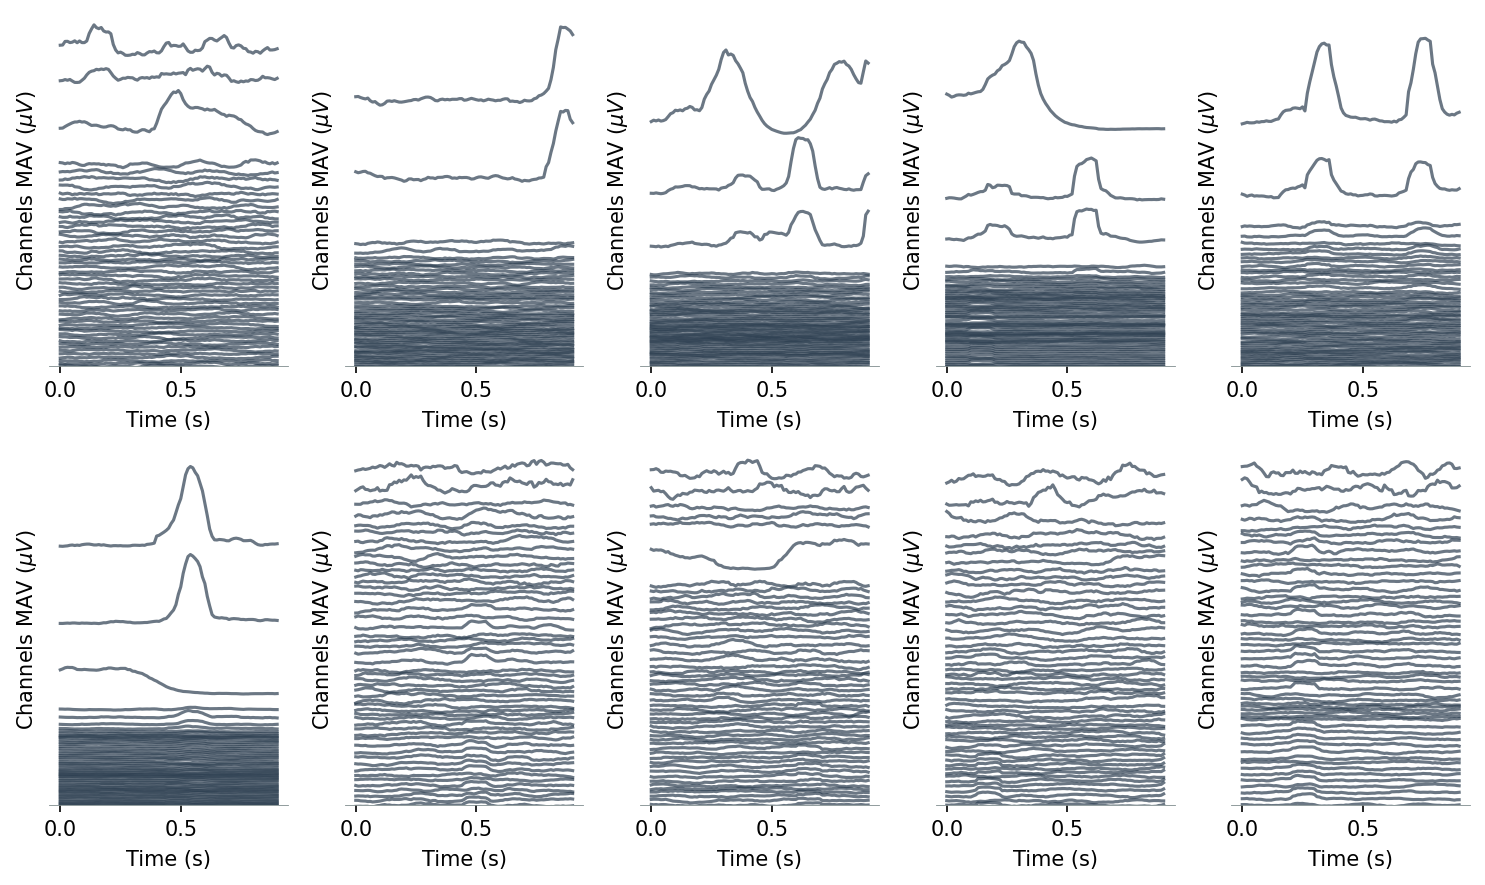

In [232]:
# plot a selected channel
task_id = 4
feature = 'mav'
wind_size = 0.1
ol = 0.9

plot_phase= 'close'  # 'open' or 'close'
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(nrows=2, ncols=5)

for rep_id in range(eng_dataset.task_rep_count[task_id]): #eng_dataset.task_rep_count[task_id]):
    flex_feat_df, ext_feat_df, rest_feat_df = pre.extract_feature_for_task_rep_per_phase(eng_dataset,
                                                                                    task_id,
                                                                                    rep_id,
                                                                                    feature,
                                                                                    wind_size,
                                                                                    overlap_perc=ol)

    if plot_phase == 'close':  # flexion/close phase
        plot_phase_df = flex_feat_df

    elif plot_phase == 'open':  # extension/ open phase
        plot_phase_df = ext_feat_df

    # get a sample of channels
    active_ch = plot_phase_df[np.arange(eng_dataset.n_channels)].mean().sort_values(ascending=False).index
    # ignore bad channels
    active_ch = [ch for ch in active_ch if ch not in bad_channels]

    ax = fig.add_subplot(gs[rep_id])
    yshift = 0
    for i, ch in enumerate(active_ch[::-1]):
        # center channel around 0
        ch_centered = plot_phase_df[ch].to_numpy() - plot_phase_df[ch].to_numpy().mean()
        current_ch_range = ch_centered.max() - ch_centered.min()
        if i >0:
            yshift = yshift + np.max([current_ch_range, prev_ch_range])

        ax.plot(plot_phase_df[TIME_VAR].to_numpy(), 
                ch_centered + yshift,
                color=COLOR_DICT['midnight_blue'], alpha = 0.7)
        prev_ch_range = current_ch_range

    ax.set_yticks([])
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Time (s)', labelpad=XLAB_PAD)
    ax.set_ylabel(r'Channels MAV ($\mu V$)', labelpad=YLAB_PAD)
    ax.set_ylim(0, yshift+current_ch_range)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR, 
            f"all_reps_sorted_task{task_id}_channels_{feature}_{plot_phase}.png"),
            dpi=300, bbox_inches='tight')


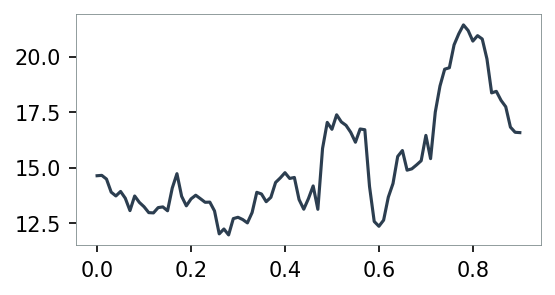

In [223]:
# plot a single channel 
plt.figure(figsize=(4, 2))
plt.plot(plot_phase_df[TIME_VAR].to_numpy(),
            plot_phase_df[active_ch[0]].to_numpy(),
            color=COLOR_DICT['midnight_blue'])



In [110]:
list_yshift

[1.601958223962589,
 3.4226586563470196,
 6.666144149829937,
 9.206296554140742,
 11.022467065969009,
 13.112287251258854,
 14.407490374029484,
 15.71663070148935,
 17.197772793357235,
 18.819853885385808,
 20.269319070591138,
 21.574348548557364,
 22.937451290192428]